In [229]:

import os
import math
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [958]:


#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"

print("Available devices ", torch.cuda.device_count())
print("Current cuda devices ", torch.cuda.current_device())
print(torch.cuda.get_device_name(device))
"""


# GPU 할당 변경하기
GPU_NUM = 4  # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')


Current cuda device  4
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/compuworks/anaconda3/envs/kdh_env/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


### audio_000200.wav 

In [230]:
file_path = 'data/'
file = 'audio_000200.wav'

NFFT = 512
Freq = 16000

y, sr = librosa.load(file_path+file, sr=16000, mono=False)

L = y[0]
R = y[1]



# 6 seconds
# zero padding 
zeros = [0]*(Freq*6 - L.shape[0])



L = np.append(L, np.asarray(zeros))
R = np.append(R, np.asarray(zeros))

fortran_L = np.asfortranarray(L)
fortran_R = np.asfortranarray(R)



In [231]:


"""stft"""
stft_L = librosa.stft(fortran_L, n_fft=NFFT, hop_length=250, center=False )
stft_R = librosa.stft(fortran_R, n_fft=NFFT, hop_length=250, center=False )


"""mag, phase"""
mag_L, phase_L = librosa.magphase(stft_L)
mag_R, phase_R = librosa.magphase(stft_R)



"""log scale"""
log_spectrogram_L = librosa.amplitude_to_db(mag_L)
log_spectrogram_R = librosa.amplitude_to_db(mag_R)


<IPython.core.display.Javascript object>


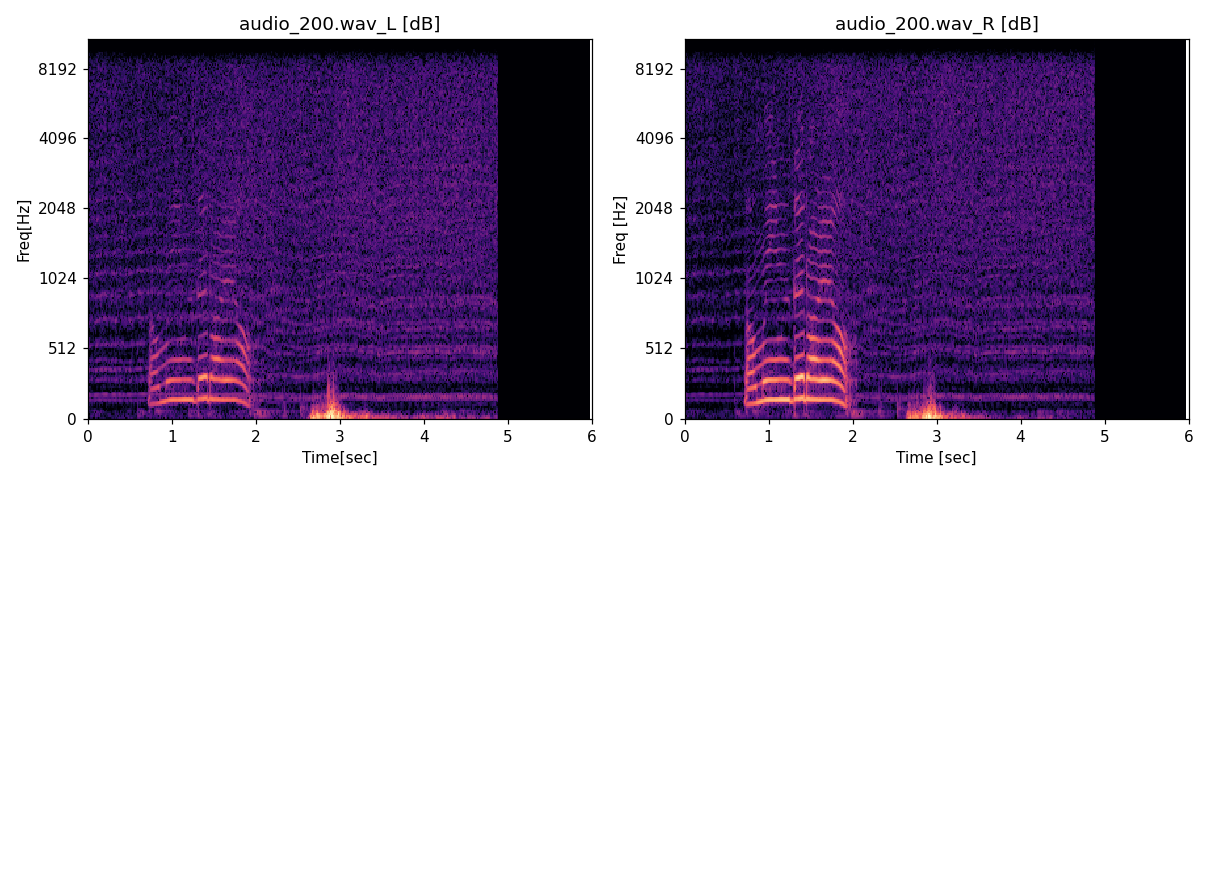

In [726]:

%matplotlib notebook
fig = plt.figure(figsize = (11,8))


# ax1 = fig.add_subplot(223)
# ax1.imshow(log_spectrogram_L, origin="lower")

# ax2 = fig.add_subplot(224)
# ax2.imshow(log_spectrogram_R, origin="lower")




"""mag_L"""
ax3 = fig.add_subplot(221)
librosa.display.specshow(log_spectrogram_L, sr=Freq, hop_length=250,
                         x_axis='time', y_axis='mel')
ax3.set_xlabel('Time[sec]')
ax3.set_ylabel('Freq[Hz]')
ax3.set_title('audio_200.wav_L [dB]')

ax3.set_xlim(0,6)
ax3.set_xticks([0,1,2,3,4,5,6])



"""mag_R"""
ax4 = fig.add_subplot(222)
librosa.display.specshow(log_spectrogram_R, sr=Freq, hop_length=250,
                         x_axis='time', y_axis='mel')
ax4.set_xlabel('Time [sec]')
ax4.set_ylabel('Freq [Hz]')
ax4.set_title('audio_200.wav_R [dB]')

ax4.set_xlim(0,6)
ax4.set_xticks([0,1,2,3,4,5,6])



plt.tight_layout()
plt.show()


### mag, phase >> stft

In [205]:


# (mag, phase) to stft

mag_L, phase_L = librosa.magphase(stft_L)
mag_R, phase_R = librosa.magphase(stft_R)

print(stft_L[1][:3])
print(phase_L[1][:3])

c = phase_L[1][:3]
print(mag_L[1][:3]*np.real(c) + mag_L[1][:3]*np.imag(c)*1j , '\n\n')


# stft = mag * np.real(phase) + 1j* mag * np.imag(phase)


[ 0.01696047+0.02744333j -0.00397896-0.00022177j -0.01226745-0.02441298j]
[ 0.52572114+0.85065697j -0.99845043-0.05564843j -0.44899757-0.89353298j]
[ 0.01696047+0.02744333j -0.00397896-0.00022177j -0.01226745-0.02441298j] 




### zero padding 부분 제거

In [763]:
def binary_search( stft ):
    min, max = 65, stft.shape[1]-2
    
    while True:
        mid = (min+max) // 2
        if   column(stft, mid) is 'true': return mid
        elif column(stft, mid) is 'up'  : min = mid+1
        elif column(stft, mid) is 'down': max = mid-1
    

    
    
def column( stft, col ):
    s = stft[:, col:col+2]
    
    target1 = set( s[:,0] )
    target2 = set( s[:,1] )
    
    if   target1 != {0j} and target2 == {0j}:   return 'true' #target = mid
    elif target1 != {0j} and target2 != {0j}:   return 'up'   #target > mid
    elif target1 == {0j} and target2 == {0j}:   return 'down' #target < mid
    
    
    
    
    
def timestretch_input(real, imag):
    res = []
    
    for idx in range(real.shape[0]):
        tmp = [real[idx,:],  imag[idx,:]]
        tmp = np.asarray(tmp)
        tmp = np.transpose(tmp)
        res.append(tmp)
    
    res = torch.as_tensor(res) 
    return res
    

In [728]:
column(stft_L, 313)

'true'

In [729]:

x_data = ['S_left.npy', 'S_right.npy', 'S_left_phase.npy','S_right_phase.npy']
y_data = np.load( file_path+ 'angle.npy')


S_left  = np.load( file_path + x_data[0] )
S_right = np.load( file_path + x_data[1] )
S_left_phase  = np.load( file_path + x_data[2] )
S_right_phase = np.load( file_path + x_data[3] )


In [742]:

STFT_left  = []
STFT_right = []
columns = []


for idx in range(y_data.shape[0]):

    # zero padding 된 부분 제거
    col = binary_search(S_left[idx]) + 1
    columns.append(col)
    
    
  #mag, phase
    """R"""
    radius_left  = S_left[:,:col,idx] 
    radius_right = S_right[:,:col,idx]
    
    
    """theta"""
    theta_left  = S_left_phase[:,:col,idx]
    theta_right = S_right_phase[:,:col,idx]
    
    cos_left = np.real( theta_left )
    sin_left = np.imag( theta_left )
    
    cos_right = np.real( theta_right )
    sin_right = np.imag( theta_right )
    
    
  #stft
    """ R*theta """
    stft_left_real = radius_left  * cos_left  
    stft_left_imag = radius_left  * sin_left
    
    stft_right_real = radius_right * cos_right
    stft_right_imag = radius_right * sin_right
    
    
    
    left  = timestretch_input(stft_left_real, stft_left_imag)
    right = timestretch_input(stft_right_real, stft_right_imag)
    
    
    STFT_left.append(left)
    STFT_right.append(right)
    
print('done...')


done...


### time stretch 

In [ ]:
# 1. zero padding 된 부분 제거
# 2. shape -> (257, cols)
# 3. fixed_rate = cols / 382 

# 4. output size -> (257, 382 +remain)
# 5. remain 제거 -> (257, 382)

In [959]:
#time stretch

import torch.nn as nn
import torchaudio.transforms as transforms



strchd_left  = torch.empty([1,257,382]).to('cuda')
strchd_right = torch.empty([1,257,382]).to('cuda')
strchd_left_phase  = torch.empty([1,257,382]).to('cuda')
strchd_right_phase = torch.empty([1,257,382]).to('cuda')



for idx in range(y_data.shape[0]):
    
    fixed_rate = math.ceil( columns[idx] / 382 * 100 ) / 100
    
    aug1 = nn.Sequential( 
            transforms.TimeStretch( hop_length=250, n_freq=257,
                                    fixed_rate=fixed_rate ) 
    )
    
    
    out_left  = aug1(STFT_left[idx])
    out_right = aug1(STFT_right[idx])
    
    m_left,  ph_left  = torchaudio.functional.magphase(out_left)
    m_right, ph_right = torchaudio.functional.magphase(out_right)
    
    
    
    ml = m_left.reshape(1,257,m_left.shape[1]).to('cuda')
    pl = ph_left.reshape(1,257,m_left.shape[1]).to('cuda')
    mr = m_right.reshape(1,257,m_left.shape[1]).to('cuda')
    pr = ph_right.reshape(1,257,m_left.shape[1]).to('cuda')
    
    
    
    strchd_left  = torch.cat( [strchd_left,  ml[:,:,:382]], dim=0 )
    strchd_right = torch.cat( [strchd_right, pl[:,:,:382]], dim=0 )
    strchd_left_phase  = torch.cat( [strchd_left_phase,  mr[:,:,:382]], dim=0 )
    strchd_right_phase = torch.cat( [strchd_right_phase, pr[:,:,:382]], dim=0 )

    
print('done...')

done...


In [960]:
torch.save( strchd_left[1:],  'data/strchd_left.pt' )
torch.save( strchd_right[1:], 'data/strchd_right.pt' )
torch.save( strchd_left_phase[1:],  'data/strchd_left_phase.pt' )
torch.save( strchd_right_phase[1:], 'data/strchd_right_phase.pt' )